In [1]:
import numpy as np
from scipy.special import lambertw
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import sparse

In [2]:
j = complex(0, 1)

def r_to_rstar(r, M):
    r = np.array(r)
    if np.any(r <= 2*M):
        raise ValueError("All r must be > 2M")
    return r + 2*M*np.log(r/(2*M) - 1)

def rstar_to_r(rs, M):
    rs = np.array(rs)
    return (2*M*(1 + lambertw(np.exp(rs/(2*M) - 1)))).real

def Vpm(r, M, l, parity):
    if parity == 'axial':
        V = (1-2*M/r)*(l*(l+1)/r**2 - 6*M/r**3)
    elif parity == 'polar':
        n = 1/2*(l-1)*(l+2)
        num = 2*(1-2*M/r)*(
            9*M**3 +
            9*n*M**2*r + 
            3*n**2*M*r**2 + 
            n**2*(1 + n)*r**3
        )
        den = r**3*(3*M + n*r)**2
        V = num/den
    else:
        raise ValueError("parity needs to be either: axial or polar")
    return V

def gaussian_wave(x, t, x0, sigma, omega):
    spatial = np.exp(-(x-x0)**2/(2*sigma**2))
    temporal = np.exp(-j*omega*(x-t))
    y = spatial*temporal
    dydt = j*omega*y
    return y, dydt

201 300
<class 'numpy.ndarray'>


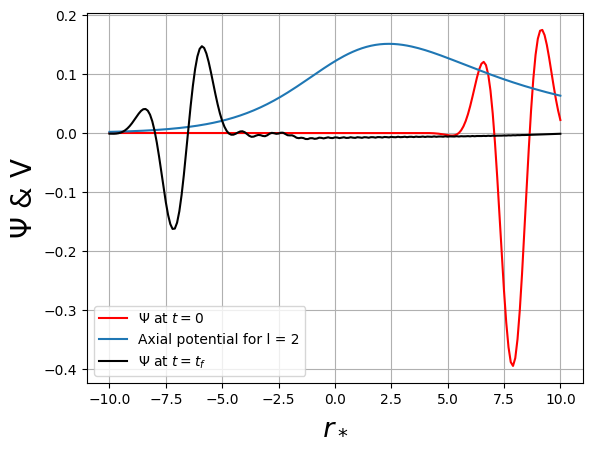

In [10]:
#Leapfrog solver
#Parameters
M = 1
c = 1
l = 2

#Define grid
dx = 0.1
dt = 0.5*dx
rstar = np.arange(-10*M, (10+dx)*M, dx)
r = rstar_to_r(rstar, M)
Nr = len(rstar) #spatial points
Nt = 300 #timesteps
print(Nr, Nt)

#Initial data
width = 1*M
rstar0 = 8*M
omega = 2
Psi0 = 1/(np.sqrt(2*np.pi*width**2))*np.exp(-(rstar - rstar0)**2/(2*width**2))*np.cos(-omega*rstar)

#Solver function
def leapfrog(rstar: np.ndarray, tsteps: int, mass: float, mode: int, parity: str, 
            y0: np.ndarray, dx: float, dt: float):
    
    if dt > dx:
        raise ValueError("CLF condition, dt <= dx must hold for stable solver")
    r = rstar_to_r(rstar, mass)
    V = Vpm(r, mass, mode, parity)

    psi_arr = np.zeros((len(rstar), tsteps), dtype = y0.dtype)
    psi_arr[:, 0] = y0
    psi_arr[1:-1, 1] = psi_arr[1:-1, 0] + 0.5*(dt/dx)**2*(psi_arr[2:, 0] + 
        psi_arr[:-2, 0] - 2*psi_arr[1:-1, 0]) - 0.5*V[1:-1]*psi_arr[1:-1, 0]*dt**2
    
    for q in range(1, tsteps - 1):
        psi_arr[1:-1, q + 1] = (2*psi_arr[1:-1, q] - psi_arr[1:-1, q - 1]
            + (dt/dx)**2*(psi_arr[2:, q] + psi_arr[:-2, q] - 2*psi_arr[1:-1, q])
            - V[1:-1]*psi_arr[1:-1, q]*dt**2
        )
        psi_arr[0, q + 1] = (1-dt/dx)*psi_arr[0, q] + dt/dx*psi_arr[1, q]
        psi_arr[-1, q + 1] = (1 - dt/dx)*psi_arr[-1, q] + dt/dx*psi_arr[-2, q]
    
    return psi_arr

#Solve
Psi = leapfrog(rstar, Nt, M, l, 'axial', Psi0, dx, dt)
Psi = Psi.transpose()
r = rstar_to_r(rstar, M)
V_axial = Vpm(r, M, 2, 'axial')
print(type(Psi))

plt.figure()
plt.plot(rstar, Psi[0], label = r'$\Psi$ at $t = 0$', color = 'red')
plt.plot(rstar, V_axial, label = 'Axial potential for l = 2')
plt.plot(rstar, Psi[-1, :], label = r'$\Psi$ at $t = t_{f}$', color = 'k')
plt.xlabel(r'$r_*$', fontsize = 20)
plt.ylabel(r'$\Psi$ & V', fontsize = 20)
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# V_all = np.zeros((len(ls), 2, Nr))
# for i, l in enumerate(ls):
#     V_all[i, 0] = Vpm(r, M, l, 'axial')
#     V_all[i, 1] = Vpm(r, M, l, 'polar')

# y = np.zeros((Nr, 3)) #index y as y[xi, tj]
# y[:,0] = (1/(np.sqrt(2*np.pi*width**2)))*np.exp(-(rstar - rstar0)**2/(2*width**2))*np.exp(-j*omega*rstar).real
# y[1:-1, 1] = y[1:-1, 0] + 0.5* c**2*(dt/dx)**2*(y[2:, 0] + y[:-2, 0] - 2*y[1:-1, 0]) # define future step


# for k in range(0, Nt):
#     y[1:-1, 2] = 2*y[1:-1, 1] - y[1:-1, 0] + c**2*(dt/dx)**2*(y[2:,1] + y[:-2, 1] - 2*y[1:-1, 1]) - V_all[0, 0, 1:-1]*y[1:-1, 1]*dt**2
#     y[0, 2] = (1-dt/dx)*y[0, 1] + dt/dx*y[1, 1]
#     y[-1, 2] = (1 - dt/dx)*y[-1, 1] + dt/dx*y[-2, 1]
#     y[:, 0] = y[:, 1]
#     y[:, 1] = y[:, 2]